## Bachelor Thesis - Informatik

### Variante 1 :
### Klassisches Neuronales Netz mit Fully Connected (Dense) Layern
***

<div align="left">
<h2><img src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExZ2hrOGtveWx0ZGFeaturessaGFsYFeaturesNzbjVhOTNyaTg2cG44anZ5eWd5a3ZyMyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/l3vRcrVqhBVSpJte0/giphy.gif" width="200" alt="Data"></h2>
</div>

Dieser Ansatz verwendet als Datengrundlage die folgenden drei Datensätze :

###### ☑️ Die Daten wurden von einem Myo-Armband per Bluetooth LE an einen ESP32S3 übertragen

###### ☑️ Sämtliche Daten wurden mit folgender Lösung [Processing-Grapher](https://github.com/chillibasket/processing-grapher.git) aufgezeichnet und als .csv-Datei gespeichert

###### ☑️ Vier Testpersonen, davon eine weibliche und drei männliche Personen standen zur Verfügung

###### ☑️ Alle Personen haben die folgenden vier Gesten in gleicher Position ausgeführt :

<img src="./Gestenbilder/Eigene_Geste_0.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_1.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_2.png" width="150">      <img src="./Gestenbilder/Eigene_Geste_3.png" width="150">

#### ▶️ Installation notwendiger Python-Bibliotheken

In [91]:
#%pip install pandas
#%pip install numpy
#%pip install seaborn
#%pip install matplotlib.pyplot
#%pip install scikit-learn
#%pip install tensorflow
#%pip install "everywhereml>=0.2.32"

#### ▶️ Importieren notwendiger Python-Bibliotheken
***

In [92]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import classification_report, confusion_matrix # type: ignore
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf # type: ignore

#### ▶️ Einlesen der aufgezeichneten Daten aus dem Quellordner
***

In [93]:
# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Faust
# Label 1 --> Daumen hoch
# Label 2 --> Schere
# Label 3 --> Gespreizte Hand


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
proband1 = []
proband2 = []
proband3 = []
proband4 = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################

for label in ['0', '1', '2', '3']:
    proband1.append(pd.read_csv('./Eigene/P1L' + label + '.csv', sep=',', header=None))     
    proband1[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband2.append(pd.read_csv('./Eigene/P2L' + label + '.csv', sep=',', header=None))        
    proband2[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband3.append(pd.read_csv('./Eigene/P3L' + label + '.csv', sep=',', header=None))        
    proband3[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband4.append(pd.read_csv('./Eigene/P4L' + label + '.csv', sep=',', header=None))        
    proband4[int(label)][64] = int(label)


##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
proband1 = pd.concat([df for df in proband1], axis=0).reset_index(drop=True)
proband2 = pd.concat([df for df in proband2], axis=0).reset_index(drop=True)
proband3 = pd.concat([df for df in proband3], axis=0).reset_index(drop=True)
proband4 = pd.concat([df for df in proband4], axis=0).reset_index(drop=True)

all_data = pd.concat([proband1, proband2, proband3, proband4])

#### ▶️ Umwandlung in geeignete Datenstrukturen
***

In [94]:
##############################################################
# Features aus Datensatz extrahieren                         #
##############################################################  
Features = all_data.drop(64, axis=1).copy()
Features = np.array(Features).astype('float32')


##############################################################
# Labels extrahieren aus Datensatz                           #
##############################################################  
Labels = all_data[all_data.columns[-1]]
Labels = np.array(Labels).astype('int')


##############################################################
# Vektorformen ausgeben                                      #
##############################################################  
Klassen = Labels.max()
eye = np.eye(Klassen + 1)

X_norm = StandardScaler().fit_transform(Features)
y_hot = np.asarray([eye[yi] for yi in Labels], dtype=int)

print(X_norm)
print(y_hot)

[[ 0.9005705  -0.22930491  0.11901031 ... -2.0931103  -0.19827153
  -0.22577184]
 [ 1.3271658  -1.2790067   0.27200556 ...  1.6073623  -0.36335716
  -0.50908846]
 [ 0.26067758  0.03312054  0.4250008  ... -2.3398085  -0.77607125
  -0.4146496 ]
 ...
 [ 0.26067758 -1.6289073  -1.3344445  ...  0.12717323  0.21444254
  -0.22577184]
 [-0.80581063 -0.4917304  -2.634904   ...  0.6205695  -0.36335716
  -0.6979662 ]
 [-0.2725665  -0.05435462 -3.8588657  ... -0.11952493 -0.11572873
  -4.097766  ]]
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]



#### ▶️ Datensatz aufteilen in Training- und Test-Daten

In [95]:
##############################################################
# Aufteilung der Datensätze in Training- und Testdaten       #
# Test-Size --> prozentualer Anteil von Gesamtdaten          #
# Random-State --> Zufallsgrad der Durchmischung             #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(X_norm, y_hot, test_size = 0.2, random_state = 100)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=100)

np.savetxt('../data/X_train.csv', X_train, delimiter=",", fmt='%f')
np.savetxt('../data/y_train.csv', y_train, delimiter=",", fmt='%d')

np.savetxt('../data/X_test.csv', X_test, delimiter=",", fmt='%f')
np.savetxt('../data/y_test.csv', y_test, delimiter=",", fmt='%d')

np.savetxt('../data/X_val.csv', X_val, delimiter=",", fmt='%f')
np.savetxt('../data/y_val.csv', y_val, delimiter=",", fmt='%d')

##############################################################
# Status der Datensätze ausgeben                             #
##############################################################
print("Form der Training-Features : ", X_train.shape)
print("Form der Test-Features : ", X_test.shape)
print("Form der Training-Labels : ", y_train.shape)
print("Form der Test-Labels : ", y_test.shape)
print()
print(Features.shape[0], "Gesamt-Features")
print(X_train.shape[0], "Training-Features")
print(X_test.shape[0], "Test-Features")
print()
print(Labels.shape[0], "Gesamt-Labels")
print(y_train.shape[0], "Training-Labels")
print(y_test.shape[0], "Test-Labels")

Form der Training-Features :  (3395, 64)
Form der Test-Features :  (1213, 64)
Form der Training-Labels :  (3395, 4)
Form der Test-Labels :  (1213, 4)

6064 Gesamt-Features
3395 Training-Features
1213 Test-Features

6064 Gesamt-Labels
3395 Training-Labels
1213 Test-Labels


#### ▶️ Machine-Learning Modell erstellen
***

In [96]:
import tensorflow as tf # type: ignore
from tensorflow import keras # type: ignore
from keras import layers # type: ignore
from keras import ops # type: ignore

##############################################################
# Hyperparameter                                             #
##############################################################

batch_size = 32
epochs = 50
initializer1='glorot_uniform'
initializer2='he_uniform'


# Format der Eingabedaten festlegen

input_shape = X_norm.shape[1:]
Klassen = y_train.shape[1]

# Modell schichtweise erstellen
model = keras.Sequential()
model.add(layers.InputLayer(input_shape))

model.add(layers.Dense(256, activation='relu' ,kernel_initializer=initializer2))
model.add(layers.Dense(128, activation='relu' ,kernel_initializer=initializer2))
model.add(layers.Dense(64, activation='relu', kernel_initializer=initializer2))
model.add(layers.Dense(Klassen, activation='softmax', kernel_initializer=initializer1))

# Modellparameter ausgeben
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,052 (226.77 KB)

 Trainable params: 58,052 (226.77 KB)

 Non-trainable params: 0 (0.00 B)

In [97]:
# Modell kompilieren
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)


# Parameter und Daten an Modell übergeben
# Training durchführen
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(),
        #keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=2)
    ]
)

Epoch 1/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2976 - loss: 1.4882 - val_accuracy: 0.4499 - val_loss: 1.1910 - learning_rate: 0.0010
Epoch 2/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5733 - loss: 1.0113 - val_accuracy: 0.5398 - val_loss: 1.0264 - learning_rate: 0.0010
Epoch 3/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6984 - loss: 0.7502 - val_accuracy: 0.5790 - val_loss: 0.9455 - learning_rate: 0.0010
Epoch 4/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7906 - loss: 0.5536 - val_accuracy: 0.6016 - val_loss: 0.9161 - learning_rate: 0.0010
Epoch 5/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8612 - loss: 0.4173 - val_accuracy: 0.6106 - val_loss: 0.9104 - learning_rate: 0.0010
Epoch 6/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9030 - loss: 0.3225 - val_accuracy: 0.5955 - val_loss: 1.0367 - learning_rate: 0.0010
Epoch 7/50
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9294 - loss: 0.2411 - 

#### ▶️ Exportiere das Modell nach C++
***

In [98]:
"""
Export NN to C++
Copy-paste the generated code inside a file named model.h or irisModel.h
in your Arduino project
"""
from everywhereml.code_generators.tensorflow import convert_model


c_header = convert_model(model, X_train, y_train, model_name='FCNN')
print(c_header)

INFO:tensorflow:Assets written to: C:\Users\Gizmo\AppData\Local\Temp\tmp9_4nkrq7\assets


INFO:tensorflow:Assets written to: C:\Users\Gizmo\AppData\Local\Temp\tmp9_4nkrq7\assets


Saved artifact at 'C:\Users\Gizmo\AppData\Local\Temp\tmp9_4nkrq7'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64), dtype=tf.float32, name='keras_tensor_88')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  2657396958480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2657396956176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2657396962128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2657396956560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2657396964624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2657396958672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2657396958288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2657669073424: TensorSpec(shape=(), dtype=tf.resource, name=None)
#pragma once

#ifdef __has_attribute
#define HAVE_ATTRIBUTE(x) __has_attribute(x)
#else
#define HAVE_ATTRIBUTE(x) 0
#endif
#if HAVE_ATTRIBUTE(aligned

#### ▶️ Ausgabe der Verlustfunktion für Training und Validation
***

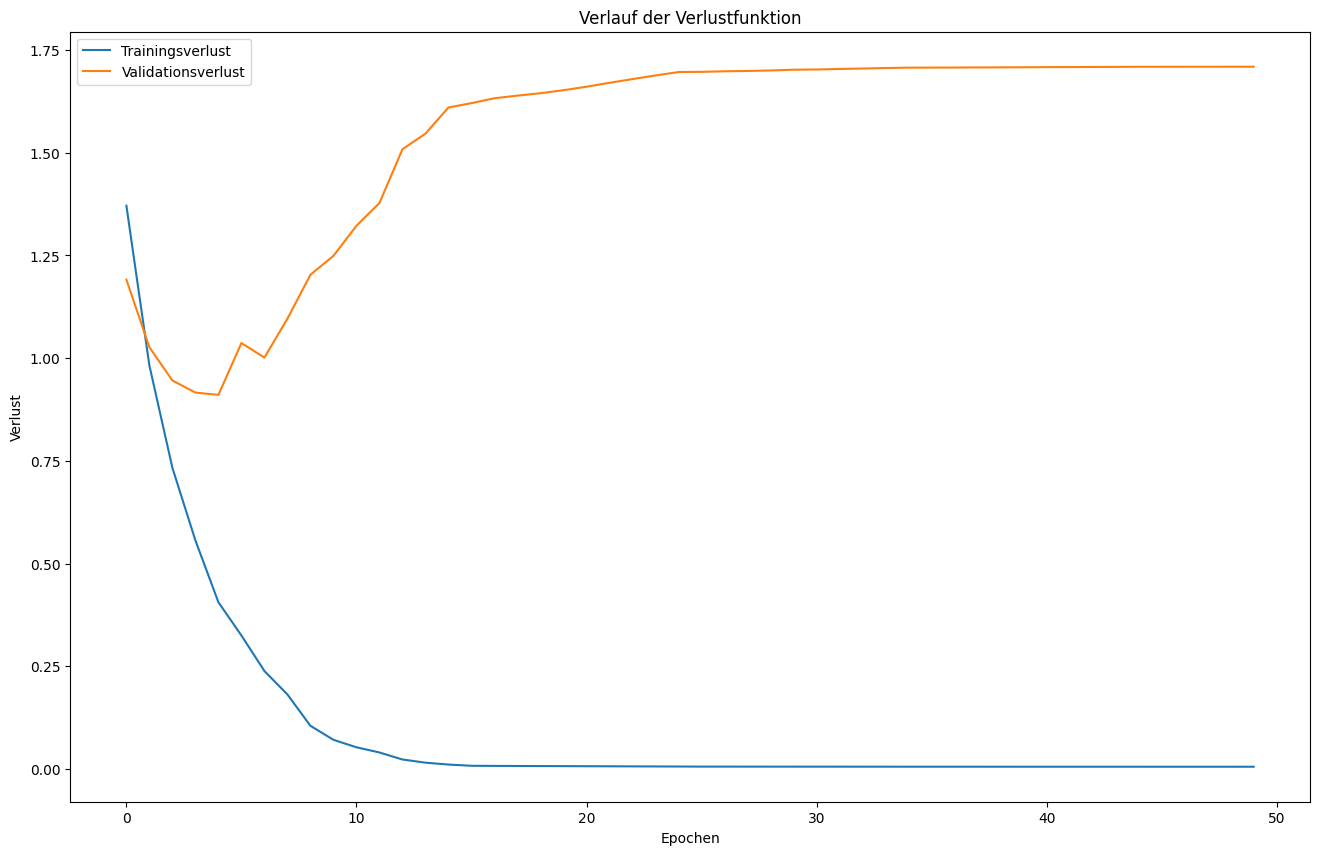

In [99]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['loss'], label="Trainingsverlust")
plt.plot(range(epochs), history.history['val_loss'], label="Validationsverlust")

plt.xlabel("Epochen")
plt.ylabel("Verlust")
plt.legend()
plt.title("Verlauf der Verlustfunktion")

plt.show()

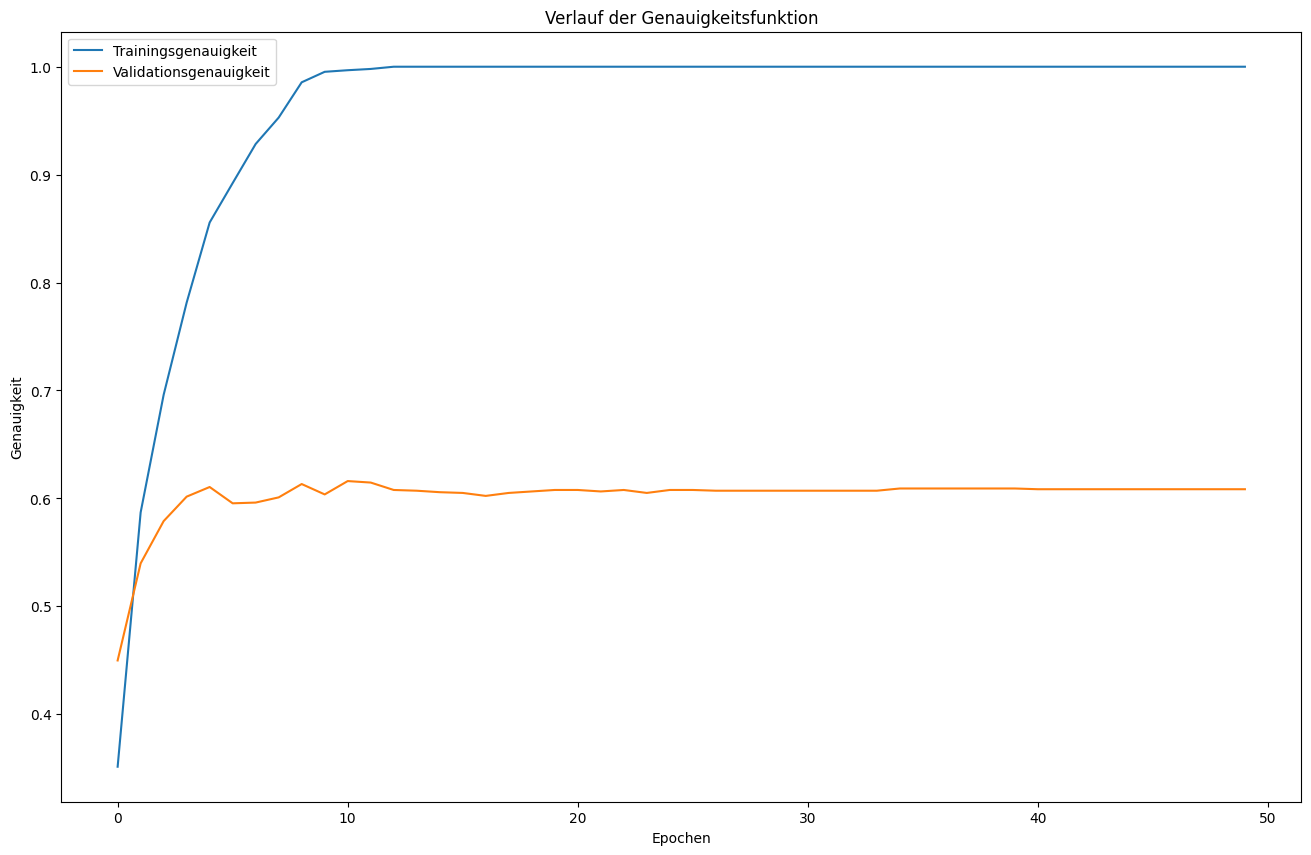

In [100]:
plt.figure(figsize=(16, 10))

plt.plot(range(epochs), history.history['accuracy'], label="Trainingsgenauigkeit")
plt.plot(range(epochs), history.history['val_accuracy'], label="Validationsgenauigkeit")

plt.xlabel("Epochen")
plt.ylabel("Genauigkeit")
plt.legend()
plt.title("Verlauf der Genauigkeitsfunktion")

plt.show()

#### ▶️ Modell auf Testdaten anwenden und evaluieren
***

In [101]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 1.6680898666381836
Test accuracy: 0.6084089279174805


In [102]:
y = model.predict(np.array(Features))[1850]
#print(X[3212])
print("Es handelt sich um Geste : " + str(np.argmax(y)))


190/190 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step
Es handelt sich um Geste : 1


#### ▶️ Metriken zur Beurteilung der Modellqualität 
***

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step


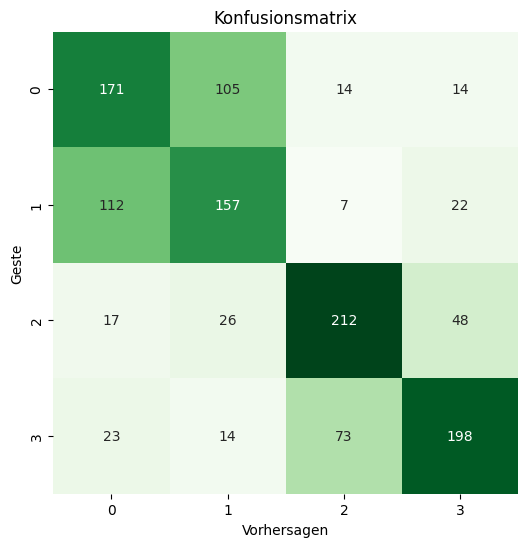

              precision    recall  f1-score   support

           0       0.53      0.56      0.55       304
           1       0.52      0.53      0.52       298
           2       0.69      0.70      0.70       303
           3       0.70      0.64      0.67       308

    accuracy                           0.61      1213
   macro avg       0.61      0.61      0.61      1213
weighted avg       0.61      0.61      0.61      1213



In [103]:
y_test_arg=np.argmax(y_test,axis=1)
y_pred = np.argmax(model.predict(X_test),axis=1)
 
cm = confusion_matrix(y_test_arg, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', cbar=False)
plt.xlabel("Vorhersagen")
plt.ylabel("Geste")
plt.title("Konfusionsmatrix")
plt.show()

print(classification_report(y_test_arg, y_pred))